In [1]:
import numpy as np
import matplotlib.pyplot as plt
from funciones_P2 import *

# PREGUNTA 2

## Estructura sin tensor

In [ ]:
# ---- DATOS DEL PROBLEMA ----

L      = 6.0          # [m] luz horizontal
alpha  = 30.0         # [deg]
E      = 206e9        # [Pa]
A      = 2.0e-6       # [m^2]
I      = 2.0e-6       # [m^4]
q      = -1000        # [N/m] 
qvert = (q*np.cos(alpha), -q*np.sin(alpha))
ne_ref = 10           # subdivisiones en viga inclinada izquierda


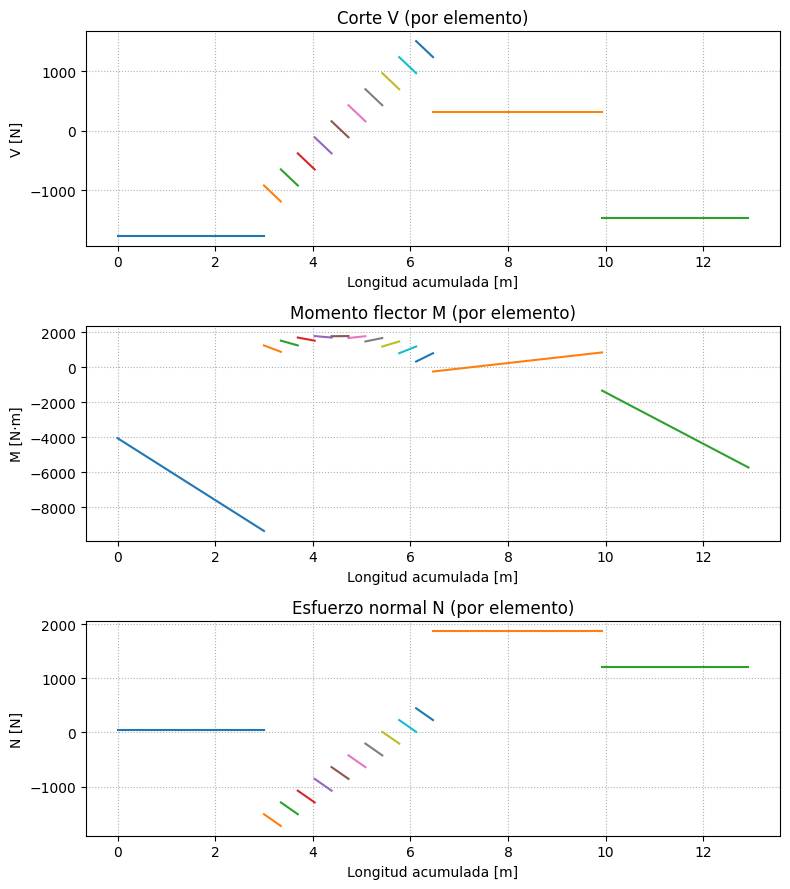

In [3]:
# ---- CÁLCULO ----

nodes, elems, left_ids = mesh_with_refinement_on_left_roof(L, alpha, ne_ref)
u, R, edata = assemble_solve(nodes, elems, E, A, I, qvert, left_ids, encastres=(0,4))
diag = diagrams_per_element(u, edata, nsamples=2) 

# ---- GRAFICOS ----

# Corte
fig, axs = plt.subplots(3,1, figsize=(8,9), sharex=False)
for k,d in enumerate(diag):
    X = d['x']; V = d['V']
    x0 = 0.0
    for j in range(k):
        x0 += diag[j]['L']
    axs[0].plot(x0+X, V, '-')
axs[0].set_title("Corte V (por elemento)")
axs[0].set_xlabel("Longitud acumulada [m]"); axs[0].set_ylabel("V [N]"); axs[0].grid(True, ls=':')

# Momento 
for k,d in enumerate(diag):
    X = d['x']; M = d['M']; x0 = sum(diag[j]['L'] for j in range(k))
    axs[1].plot(x0+X, M, '-')
axs[1].set_title("Momento flector M (por elemento)")
axs[1].set_xlabel("Longitud acumulada [m]"); axs[1].set_ylabel("M [N·m]"); axs[1].grid(True, ls=':')

# Esfuerzo normal
for k,d in enumerate(diag):
    X = d['x']; N = d['N']; x0 = sum(diag[j]['L'] for j in range(k))
    axs[2].plot(x0+X, N, '-')
axs[2].set_title("Esfuerzo normal N (por elemento)")
axs[2].set_xlabel("Longitud acumulada [m]"); axs[2].set_ylabel("N [N]"); axs[2].grid(True, ls=':')
plt.tight_layout()
plt.show()

In [4]:
# ---- RESULTADOS NUMÉRICOS ----

print("Reacciones base izq (nodo 0):", R[0:3])
print("Reacciones base der (nodo 4):", R[3*4:3*4+3])
e0 = left_ids[0]
print("Extremos locales elem", e0, "(N1, V1, M1, N2, V2, M2) =", element_end_forces_local(u, edata[e0]))

Reacciones base izq (nodo 0): [-1767.01052298   -39.80551369 -4055.66622578]
Reacciones base der (nodo 4): [-1464.25569764 -1208.76110906 -3056.77434934]
Extremos locales elem 1 (N1, V1, M1, N2, V2, M2) = [-1510.37324481  -917.97784756  1245.36534318  1292.9657126
   648.28549517 -1516.65011194]


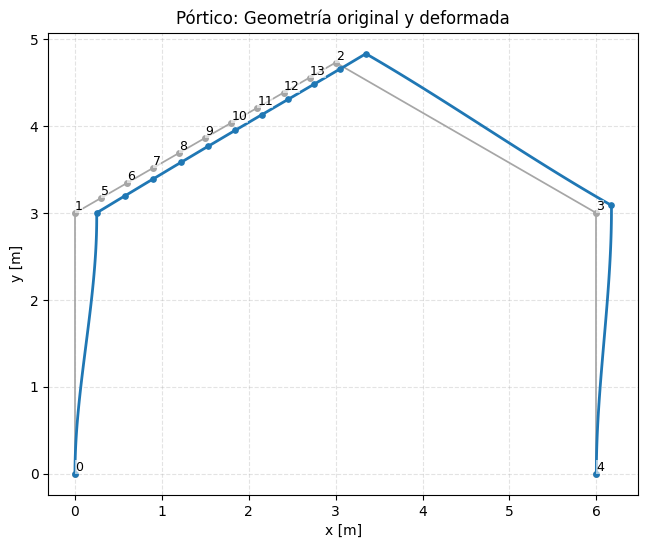

In [5]:
# ---- GRÁFICO ESTRUCTURA ----

scale = 10
ax = plot_portico(nodes, elems, U=u, scale=scale, index_base=0,
                  dof_per_node=3, annotate=True, T_beam_func=T_beam)
plt.show()

## Estructura con tensor

In [6]:
# ---- Malla base ----
nodes, elems, left_ids = mesh_with_refinement_on_left_roof(L, alpha, ne_ref)

# ---- Agregar tensor horizontal entre cabezas de columnas ----
elems, tie_ids = add_horizontal_tie(nodes, elems, n1=1, n2=3)

# ---- Resolver considerando el tensor ----
U, R, edata = assemble_solve_with_tie(
    nodes, elems, E, A, I,
    qvert,
    left_roof_elem_ids=left_ids,
    tie_elem_ids=tie_ids,
    A_tie_factor=0.5,
    encastres=(0, 4)
)

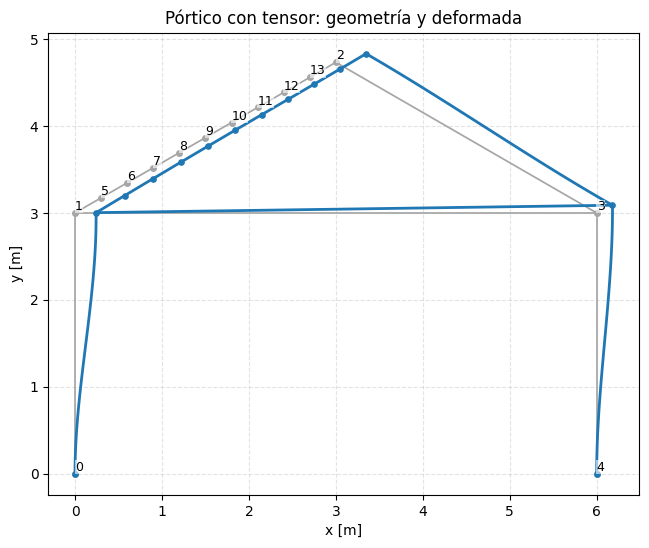

In [7]:
# --- Graficar ---

scale = 10.0
ax = plot_portico_with_tie(
    nodes, elems, U=U, scale=scale,
    tie_elem_ids=tie_ids
)
plt.show()

## Comparación de ambos pórticos

In [8]:
# ---- COMPARACIÓN DE DESPLAZAMIENTOS CON Y SIN TENSOR ----

# SIN TENSOR
U0, R0, data0 = assemble_solve(
    nodes, elems, E, A, I,
    qvert,
    left_roof_elem_ids=left_ids,
    encastres=(0,4)
)
print("\n--- Desplazamientos SIN tensor ---")
report_nodes_disp(U0, nodes=(1,2,3), index_base=0)


# CON TENSOR
elems_tie, tie_ids = add_horizontal_tie(nodes, elems, n1=1, n2=3)
U1, R1, data1 = assemble_solve_with_tie(
    nodes, elems_tie, E, A, I,
    qvert,
    left_roof_elem_ids=left_ids,
    tie_elem_ids=tie_ids,
    A_tie_factor=0.5,   # A/2
    encastres=(0,4)
)
print("\n--- Desplazamientos CON tensor ---")
report_nodes_disp(U1, nodes=(1,2,3), index_base=0)


--- Desplazamientos SIN tensor ---
Nodo |       ux [m]       uy [m]      |u| [m]  theta [rad]
------------------------------------------------------------
   1 | 1.919257e-02 -6.860997e-04 1.920483e-02 6.728331e-03
   2 | 2.923551e-02 9.282001e-03 3.067362e-02 1.191328e-03
   3 | 1.441539e-02 9.777604e-03 1.741852e-02 3.912654e-03

--- Desplazamientos CON tensor ---
Nodo |       ux [m]       uy [m]      |u| [m]  theta [rad]
------------------------------------------------------------
   1 | 1.884735e-02 -6.860997e-04 1.885984e-02 6.662102e-03
   2 | 2.923551e-02 9.182657e-03 3.064370e-02 1.191328e-03
   3 | 1.476060e-02 9.777604e-03 1.770528e-02 3.978884e-03


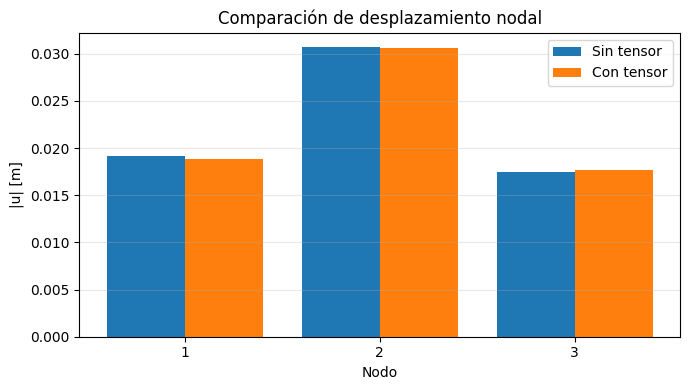

In [9]:
# ---- Gráfico comparativo ----

ax = barplot_nodes_disp(
    [U0, U1], labels=["Sin tensor", "Con tensor"],
    nodes=(1,2,3), index_base=0
)